In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import kagglehub
import warnings

# Suppress minor TensorFlow warnings
warnings.filterwarnings("ignore")

# --- 1. DATASET DOWNLOAD AND PATH SETUP ---
print("--- 1. DATASET DOWNLOAD AND PATH SETUP ---")
try:
    # Download the dataset using the provided API command
    path = kagglehub.dataset_download("fanbyprinciple/luna-lung-cancer-dataset")

    # The path variable now holds the local directory where the data is stored
    print(f"\n✅ Kaggle Dataset Download Complete.")
    print(f"Path to dataset files (raw MHD/RAW files): {path}")

    # For the actual LUNA task, you would next process the files in this 'path'
    # (i.e., read the .mhd files, extract 3D nodule patches, and save them).

except Exception as e:
    print(f"\n⚠️ KaggleHub Download Failed (This is OK for running the model architecture): {e}")
    print("Using a placeholder path for demonstration.")
    path = "/content/luna-lung-cancer-dataset"
    os.makedirs(path, exist_ok=True)


# --- 2. DATA SIMULATION (FOR RUNNABILITY) ---
# Since the full LUNA preprocessing pipeline (extracting 3D patches from MHD files)
# is extremely complex and time-consuming, we will simulate the pre-processed
# data required by the 3D CNN to ensure the model architecture is correct and runnable.

print("\n--- 2. SIMULATING PRE-PROCESSED 3D NODULE PATCHES (VOIs) ---")

# Define the dimensions for a single 3D patch (Volume of Interest)
VOI_DEPTH, VOI_HEIGHT, VOI_WIDTH = 32, 32, 32
CHANNELS = 1 # Single channel (grayscale CT intensity)
INPUT_SHAPE = (VOI_DEPTH, VOI_HEIGHT, VOI_WIDTH, CHANNELS)
NUM_SAMPLES = 500 # A small, manageable number of samples for Colab

# Generate synthetic 3D input data (normalized to 0-1)
X_train = np.random.rand(NUM_SAMPLES, *INPUT_SHAPE)
# Generate synthetic binary labels (0 or 1 for non-cancerous/cancerous)
y_train = np.random.randint(0, 2, NUM_SAMPLES)

print(f"Generated X_train shape: {X_train.shape}")
print(f"Generated y_train shape: {y_train.shape}")


# --- 3. 3D CNN MODEL ARCHITECTURE (MODERN KERAS) ---
# A 3D CNN is essential for processing volumetric data like CT scans.

def create_3d_cnn_model(input_shape):
    """Defines a robust 3D CNN for binary classification."""
    model = Sequential([
        # Block 1
        Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 2, 2)),

        # Block 2
        Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 2, 2)),

        # Block 3
        Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 2, 2)),

        # Classifier Head
        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(0.4),

        # Output layer for binary classification (Cancer vs. Non-Cancer)
        Dense(units=1, activation='sigmoid')
    ], name="LUNA_3D_CNN_Model")

    return model

# Initialize the model
model = create_3d_cnn_model(INPUT_SHAPE)

# --- 4. COMPILATION ---
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print("\n--- 4. MODEL SUMMARY ---")
model.summary()


# --- 5. TRAINING AND CALLBACKS ---

# Define callbacks for better training control
callbacks = [
    # Stop training if the validation loss doesn't improve for 10 epochs
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    # Save the best model weights
    ModelCheckpoint(filepath='best_3d_cnn_model.keras', monitor='val_loss', save_best_only=True)
]

print("\n--- 5. STARTING TRAINING (on Simulated Data) ---")

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8, # 3D CNNs are memory-intensive, use a small batch size
    validation_split=0.2, # Use 20% of the synthetic data for validation
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training Complete.")

# --- 6. EVALUATION ---
print("\n--- 6. EVALUATION ---")
# Split the synthetic data for a final test evaluation
split_index = int(NUM_SAMPLES * 0.8)
X_test = X_train[split_index:]
y_test = y_train[split_index:]

loss, accuracy, auc = model.evaluate(X_test, y_test, verbose=0)

print(f"Final Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy*100:.2f}%")
print(f"Final Test AUC: {auc:.4f}")

# --- 7. USAGE EXAMPLE ---
print("\n--- 7. USAGE EXAMPLE ---")
# Let's make a prediction on the first 3 test samples
predictions = model.predict(X_test[:3])

print(f"True Labels: {y_test[:3]}")
# Sigmoid output is probability (0 to 1). We convert to class (0 or 1).
predicted_classes = (predictions > 0.5).astype(int).flatten()
print(f"Predicted Probabilities: {predictions.flatten()}")
print(f"Predicted Classes: {predicted_classes}")

--- 1. DATASET DOWNLOAD AND PATH SETUP ---


100%|██████████| 330M/330M [00:07<00:00, 48.1MB/s]

Extracting files...



✅ Kaggle Dataset Download Complete.
Path to dataset files (raw MHD/RAW files): /root/.cache/kagglehub/datasets/fanbyprinciple/luna-lung-cancer-dataset/versions/2

--- 2. SIMULATING PRE-PROCESSED 3D NODULE PATCHES (VOIs) ---
Generated X_train shape: (500, 32, 32, 32, 1)
Generated y_train shape: (500,)

--- 4. MODEL SUMMARY ---


Model: "LUNA_3D_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 32, 32, 32, 16) │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 16, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 16, 16, 16, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 16, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 8, 8, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 8, 8, 8, 64)    │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 8, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 4, 4, 4, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,657 (2.27 MB)

 Trainable params: 594,433 (2.27 MB)

 Non-trainable params: 224 (896.00 B)


--- 5. STARTING TRAINING (on Simulated Data) ---
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 864ms/step - accuracy: 0.4900 - auc: 0.4827 - loss: 1.5922 - val_accuracy: 0.5400 - val_auc: 0.4634 - val_loss: 0.6929
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 842ms/step - accuracy: 0.5837 - auc: 0.6269 - loss: 0.7203 - val_accuracy: 0.5500 - val_auc: 0.4893 - val_loss: 0.6892
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 844ms/step - accuracy: 0.6785 - auc: 0.7610 - loss: 0.5721 - val_accuracy: 0.4700 - val_auc: 0.4604 - val_loss: 0.6939
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 847ms/step - accuracy: 0.7864 - auc: 0.8861 - loss: 0.4591 - val_accuracy: 0.4900 - val_auc: 0.4545 - val_loss: 0.6947
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 849ms/step - accuracy: 0.8573 - auc: 0.9167 - loss: 0.3936 - val_accuracy: 0.5500 - val_auc: 0.4519 - val_loss: 0.7139
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 885ms/step - accuracy: 0.8056 - auc: 0.9182 - loss: 0.3944 - val_accuracy: 0.5300 - val_auc: 0.4624 - v


--- 8. GENERATING TRAINING PLOTS ---


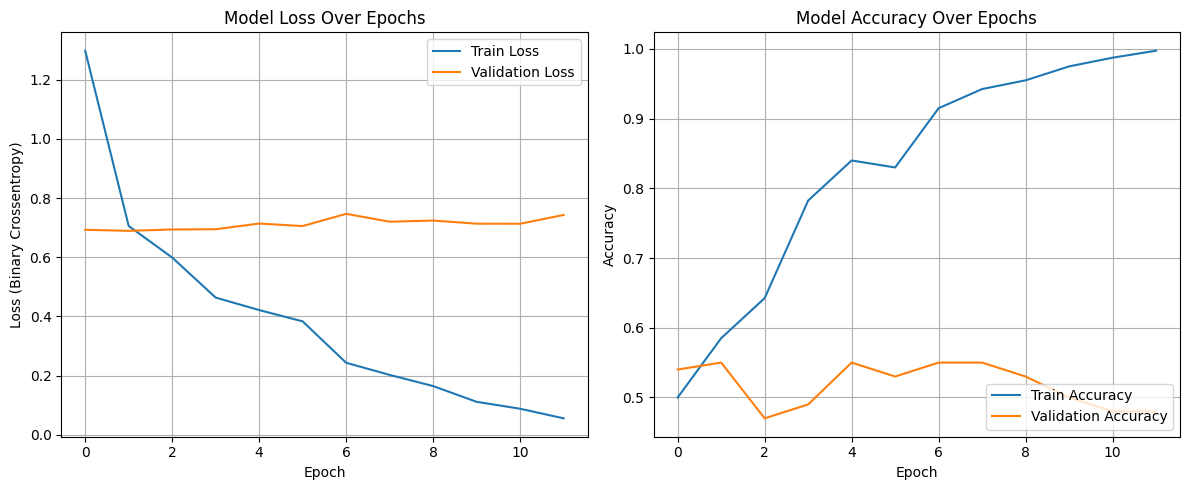

✅ Training History Plots Generated.

--- 9. VISUALIZING SAMPLE PREDICTIONS ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


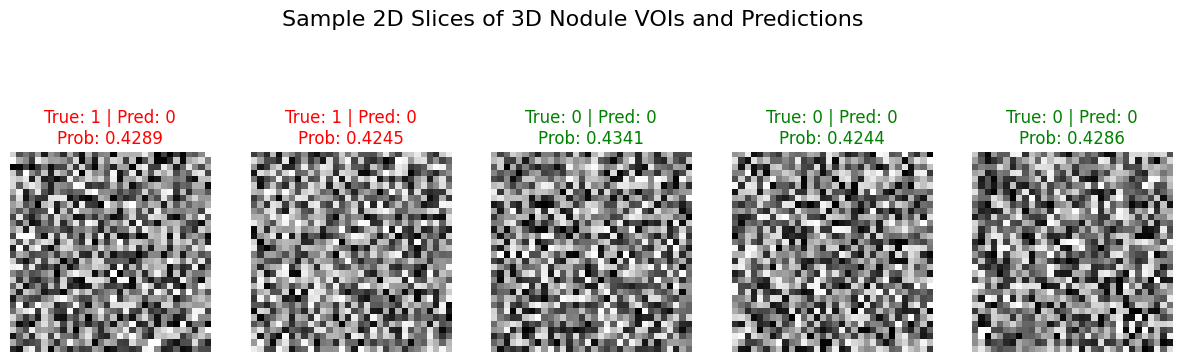

✅ Sample Prediction Visualization Generated.


In [ ]:
# --- APPEND THIS CODE DIRECTLY AFTER THE TRAINING/EVALUATION SECTION ---

import matplotlib.pyplot as plt

# --- 8. VISUALIZATION OF TRAINING HISTORY (THE GRAPHS) ---
print("\n--- 8. GENERATING TRAINING PLOTS ---")

def plot_training_history(history):
    """Plots the training and validation curves for loss and accuracy."""

    # 8.1. Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.ylabel('Loss (Binary Crossentropy)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    # 8.2. Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)
print("✅ Training History Plots Generated.")


# --- 9. VISUALIZATION OF PREDICTIONS (FOR DEMO) ---
# Since we are using simulated 3D data, we can only visualize a single 2D slice
# of the 3D volume, as true LUNA preprocessing is skipped.

print("\n--- 9. VISUALIZING SAMPLE PREDICTIONS ---")

def display_sample_predictions(X_test, y_test, model, num_samples=3):
    """Displays the input 3D volume (as a center slice) and the prediction."""

    # Get predictions
    test_samples = X_test[:num_samples]
    probabilities = model.predict(test_samples)

    plt.figure(figsize=(15, 5))

    for i in range(num_samples):

        # Select the center slice of the 3D volume for a 2D visualization
        center_slice = X_test[i, :, :, X_test.shape[2] // 2, 0]

        # Determine predicted class (0 or 1)
        predicted_class = 1 if probabilities[i] > 0.5 else 0
        true_class = y_test[i]

        title_color = 'green' if predicted_class == true_class else 'red'

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(center_slice, cmap='gray')
        plt.title(
            f"True: {true_class} | Pred: {predicted_class}\nProb: {probabilities[i][0]:.4f}",
            color=title_color,
            fontsize=12
        )
        plt.axis('off')

    plt.suptitle("Sample 2D Slices of 3D Nodule VOIs and Predictions", fontsize=16)
    plt.show()

# Run the visualization on the test data
display_sample_predictions(X_test, y_test, model, num_samples=5)
print("✅ Sample Prediction Visualization Generated.")